
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br>

<br>

### Credits:

* [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

In [3]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

In [4]:
# symbolischen Variablen anlegen
t, l, M, m, g = symbols('t l M m g')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)
display(Matrix([LE_x, LE_theta.simplify()]))

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True) 
sol_x_dd = Eq(x_dd-solutions[x_dd], 0)
sol_theta_dd = Eq(theta_dd - solutions[theta_dd], 0)
#display(Matrix([sol_x_dd, sol_theta_dd]))

⎡        ⎛            2                     ⎞⎤
⎢      m⋅⎝2⋅l⋅sin(θ)⋅θ̇  - 2⋅l⋅cos(θ)⋅θ̈ + 2⋅ẍ⎠⎥
⎢M⋅ẍ + ──────────────────────────────────────⎥
⎢                        2                   ⎥
⎢                                            ⎥
⎣      l⋅m⋅(-g⋅sin(θ) + l⋅θ̈ - cos(θ)⋅ẍ)      ⎦

### Umwandlung des symbolischen Gleichungssystems in numerische Funktionen mit `sympy.lambdify`.

In [5]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,theta,theta_d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,theta,theta_d), solutions[theta_dd])

def dSdt(S, t, g, M, m, l):
    x, v, theta, omega = S
    return [
        dxdt(v),
        dvdt(t,g,M,m,l,theta, omega),
        dthetadt(omega),
        domegadt(t,g,M,m,l,theta,omega)
    ]

### Daten generieren

time.shape: (85,) <class 'numpy.ndarray'>
x.shape: (85,)
theta.shape: (85,)
data.shape: (85, 2)


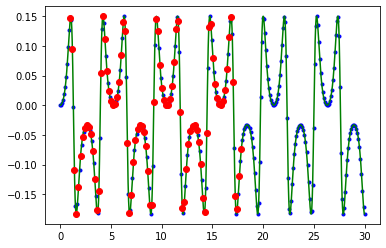

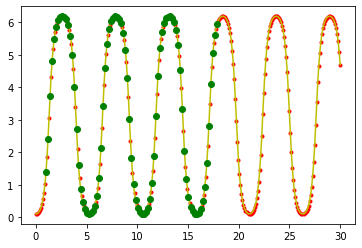

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 30                          # s 
samples = 300                    # n 
t = np.linspace(0, t1, samples)  # s

g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(g, M, m, l))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren (für DeepXDE)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 180, 2 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen: (nur nötig wenn 1 Model mit 2 Outputs genutzt wird)
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T
print('time.shape:', t_data.shape, type(t_data))
print('x.shape:', x_data.shape)
print('theta.shape:', theta_data.shape)
print('data.shape:', data.shape)


# Visualisierung 
plt.plot(t, x, 'b.')
plt.plot(t_new, x_f(t_new), 'g-')
plt.plot(t_data, data[:,0], 'ro') # data[:,1] --> x_data
plt.show()

plt.plot(t, theta, 'r.')
plt.plot(t_new, theta_f(t_new), 'y-')
plt.plot(t_data, data[:,1], 'go') # data[:,1] --> theta_data
plt.show()

In [7]:
import torch.nn as nn

class FCN(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### NN 

In [8]:
import torch

t = torch.Tensor(t).view(-1,1)
t_data = torch.Tensor(t_data).view(-1,1)
x_data = torch.Tensor(x_data).view(-1,1)
theta_data = torch.Tensor(theta_data).view(-1,1)
data = torch.Tensor(data).view(-1,2)

print('t:', t.shape)
print('t_data:', t_data.shape)
print('x_data:', x_data.shape)
print('theta_data:', theta_data.shape)
print('data:', data.shape)

t: torch.Size([300, 1])
t_data: torch.Size([85, 1])
x_data: torch.Size([85, 1])
theta_data: torch.Size([85, 1])
data: torch.Size([85, 2])


In [9]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

    
def plot_my_result(t, x, theta, t_data, data, pred, ps=None):
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    fig.suptitle(name_plot, fontsize=10)
    
    # wahren Werte
    plt.plot(t, x, 'k--', linewidth=2, alpha=0.8, label="numerical solution $x$")
    plt.plot(t, theta, 'b--', linewidth=2, alpha=0.8, label=r"numerical solution $\theta$")
    
    # Messwerte
    plt.scatter(t_data, data[:,0], s=30, color="grey", label='Training data $x$')
    plt.scatter(t_data, data[:,1], s=30, color="royalblue", label=r'Training data $\theta$')
    
    # Zeitpunkte der Physik Loss berechnung:
    if ps is not None:
        plt.scatter(ps, -3*torch.ones_like(ps), s=20, color="limegreen", alpha=0.4, label='physics trainings')
    
    # Prediction
    plt.plot(t, pred[:,0], color="black", linewidth=2, alpha=0.8, label="Prediction $x$")
    plt.plot(t, pred[:,1], color="blue", linewidth=2, alpha=0.8, label=r"Prediction $\theta$")
    
    plt.text(torch.max(t)*1.01,torch.max(data),"episode: %i"%(i),fontsize=16,color="k")
    
    
    x_max = torch.max(t)
    y_min = torch.min(pred[:,1])
    y_max = torch.max(pred[:,1])
    
    plt.xlim(0, t1)
    plt.ylim(-1, 6.3)
    
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #ax.get_yaxis().set_ticks([])
    plt.axis("off")

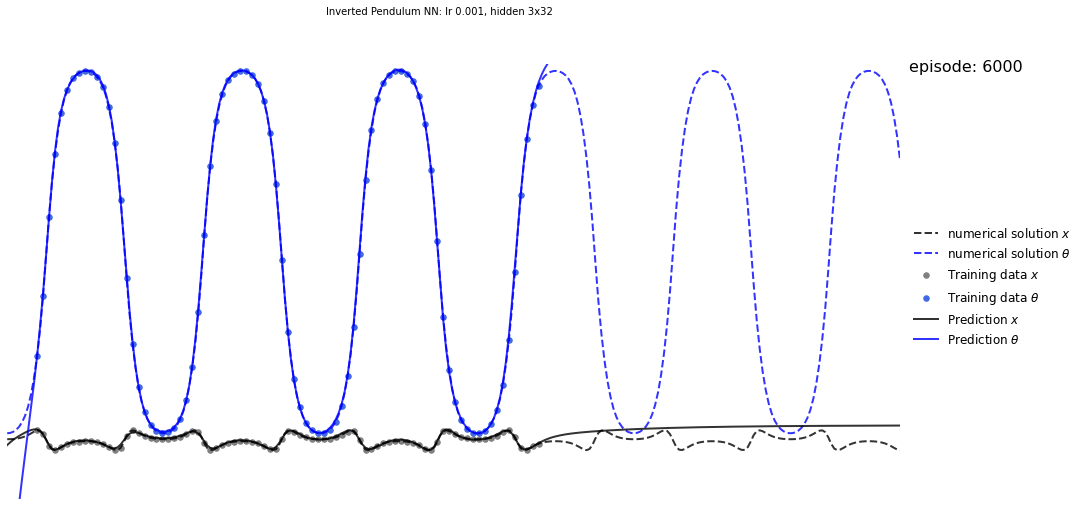

In [12]:
torch.manual_seed(123)

lr_data = 1e-3
num_layers = 3
num_hidden = 32

model = FCN(1,2,num_hidden,num_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=lr_data)

episodes = 6000
num_save_plot = round(episodes/60) # übernimmt 60 Bilder ins gif

files = []
name_plot = 'Inverted Pendulum NN: lr %s, hidden %sx%s'%(lr_data, num_layers, num_hidden)
name_gif = 'NN_lr_%s_hidden_%sx%s_episodes_%s.gif'%(lr_data, num_layers, num_hidden, episodes)

for i in range(1, episodes+1):

    optimizer.zero_grad()

    pred = model(t_data)

    loss = torch.mean((pred - data)**2) 

    loss.backward() 
    optimizer.step() 

    if (i) % num_save_plot == 0: 

        pred = model(t).detach()

        plot_my_result(t, x, theta, t_data, data, pred)

        file = "plots/nn_%.8i.png"%(i)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i) % episodes == 0: plt.show()
        else: plt.close("all")

#save_gif_PIL(name_gif, files, fps=5, loop=0)       

## PINN 

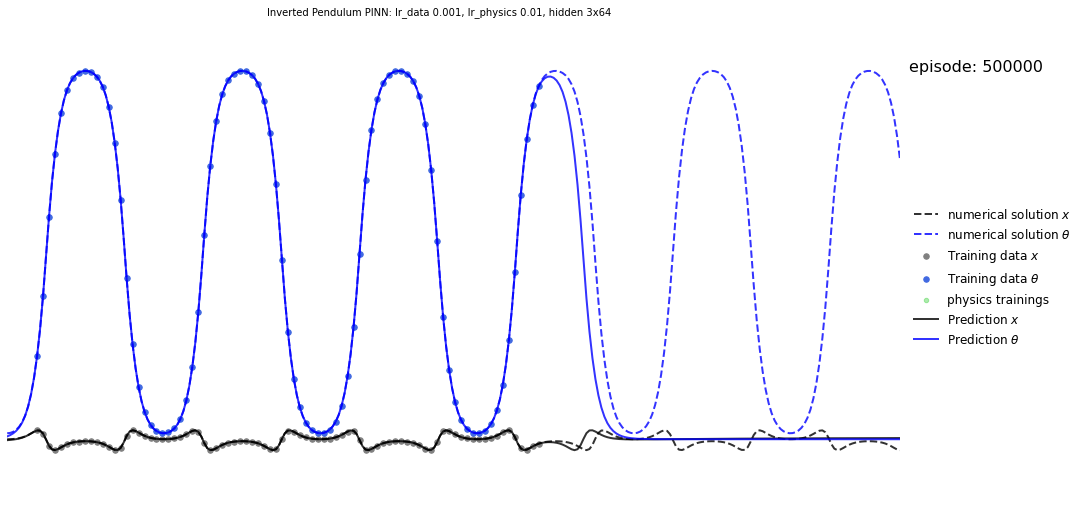

duration: 2649 [s]


In [13]:
import time
from torch import sin, cos

t_physics = torch.linspace(0,t1,t1*5).view(-1,1).requires_grad_(True)

torch.manual_seed(123)


lr_data = 1e-3
lr_physics = 1e-2
num_layers = 3
num_hidden = 64

model = FCN(1,2,num_hidden,num_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=lr_data)


episodes = 500000
num_save_plot = round(episodes/1000) 


files = []
name_plot = 'Inverted Pendulum PINN: lr_data %s, lr_physics %s, hidden %sx%s'%(lr_data, lr_physics,num_layers, num_hidden)
name_gif = 'PINN_lr_data_%s_lr_physics_%s_hidden_%sx%s_episodes_%s.gif'%(lr_data, lr_physics,num_layers, num_hidden, episodes)


start = time.time()
for i in range(1, episodes+1):

    optimizer.zero_grad()

    # normal loss
    pred = model(t_data)
    loss_data = torch.mean((pred - data)**2) 

    # physics
    pred = model(t_physics)
    
    x_p = pred[:,0].view(-1,1)
    x_d_p = torch.autograd.grad(x_p, t_physics, torch.ones_like(x_p), create_graph=True)[0]
    x_dd_p = torch.autograd.grad(x_d_p, t_physics, torch.ones_like(x_d_p), create_graph=True)[0]
    
    theta_p = pred[:,1].view(-1,1)
    theta_d_p = torch.autograd.grad(theta_p, t_physics, torch.ones_like(theta_p), create_graph=True)[0]
    theta_dd_p = torch.autograd.grad(theta_d_p, t_physics, torch.ones_like(theta_d_p), create_graph=True)[0]
    
    sin_theta_p = sin(theta_p)
    cos_theta_p = cos(theta_p)
     
    physics_x = (M+m)*x_dd_p - m*l*theta_dd_p*cos_theta_p + m*l*theta_d_p**2*sin_theta_p
    physics_theta = l*theta_dd_p - x_dd_p*cos_theta_p - g*sin_theta_p

    physics = torch.cat((physics_x, physics_theta), 1)
    
    loss_physics = lr_physics*torch.mean(physics**2)

    loss = loss_data + loss_physics
    loss.backward() 
    optimizer.step() 
    
    
    if (i) % num_save_plot == 0:         
        
        pred = model(t).detach()
        ps = t_physics.detach()
        
        plot_my_result(t, x, theta, t_data, data, pred, ps)
        
        file = "plots/pinn_%.8i.png"%(i)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i) % episodes == 0: plt.show()
        else: plt.close("all")
            

print('duration: %s [s]' % round(time.time() - start))            
save_gif_PIL(name_gif, files, fps=15, loop=0)  

## DeepXDE 

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
from deepxde.backend import sin


def ode_system(t, y):

    x, theta = y[:, 0:1], y[:, 1:]
    
    x_d = dde.grad.jacobian(x, t)
    theta_d = dde.grad.jacobian(theta, t)
    
    x_dd = dde.grad.hessian(x, t)
    theta_dd = dde.grad.hessian(theta, t)
    
    #sin_theta = dde.backend.backend.sin(theta)
    #cos_theta = dde.backend.backend.sin(1.57-theta)
    
    eq_x = (M+m)*x_dd - m*l*theta_dd*theta + m*l*theta_d**2*theta
    eq_theta = l*theta_dd - x_dd*theta - g*theta
    
    return [eq_x, eq_theta]


def boundary(_, on_initial):
    return on_initial


def func(t):
    return np.hstack((x_f(t), theta_f(t)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.IC(geom, x_f, boundary, component=0)
ic2 = dde.IC(geom, theta_f, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 50, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)